In [88]:
#Importing Libraries
import praw
from textblob import TextBlob
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models
from gensim.models import LdaModel
from nltk.corpus import stopwords
import networkx as nx
import community.community_louvain as community_louvain
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KARTIK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
# Set up Reddit API client
reddit = praw.Reddit(client_id='3gDqynjBkCCW9aJeXhKRtg', 
                     client_secret='uNQ3Lsw5Qqlk6mAbEU1RlWH_G33O-Q', 
                     user_agent='Tata u/Kaishi_Light')
#fetching posts
posts = reddit.subreddit('all').search("Tata Motors", sort='relevance', time_filter='all', limit=2000)
data = []

#setting time period
start_date = datetime.datetime(2021, 1, 5)  # Set your start date
end_date = datetime.datetime(2024, 7, 31) 

#creating data and performing sentimental analysis
for post in posts:
    post_date = datetime.datetime.fromtimestamp(post.created_utc)
    if start_date <= post_date <= end_date:
        data.append({
            'Post': post.title,
            'Sentiment': TextBlob(post.title).sentiment.polarity,
            'Created_UTC': post_date,
            'Upvotes': post.score,
            'Timestamp':datetime.datetime.utcfromtimestamp(post.created_utc)
        })


C:\Users\KARTIK\AppData\Local\Temp\ipykernel_23524\3065261687.py:22: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  'Timestamp':datetime.datetime.utcfromtimestamp(post.created_utc)


In [44]:
#Making Dataframe and checking first 5 data points
df=pd.DataFrame(data)
df.head()

,Post,Sentiment,Created_UTC,Upvotes,Timestamp
0,DD | TATA MOTORS,0.0,2024-07-06 12:57:03,65,2024-07-06 07:27:03
1,Can I buy Tata Motors now?,0.0,2024-03-02 07:04:01,29,2024-03-02 01:34:01
2,Should we hold tata motors until the de merger?,0.0,2024-07-25 12:33:43,4,2024-07-25 07:03:43
3,My opinion on why Tata Motors is overvalued,0.0,2024-03-05 13:22:31,45,2024-03-05 07:52:31
4,Tata Motors,0.0,2024-07-25 11:15:36,3,2024-07-25 05:45:36


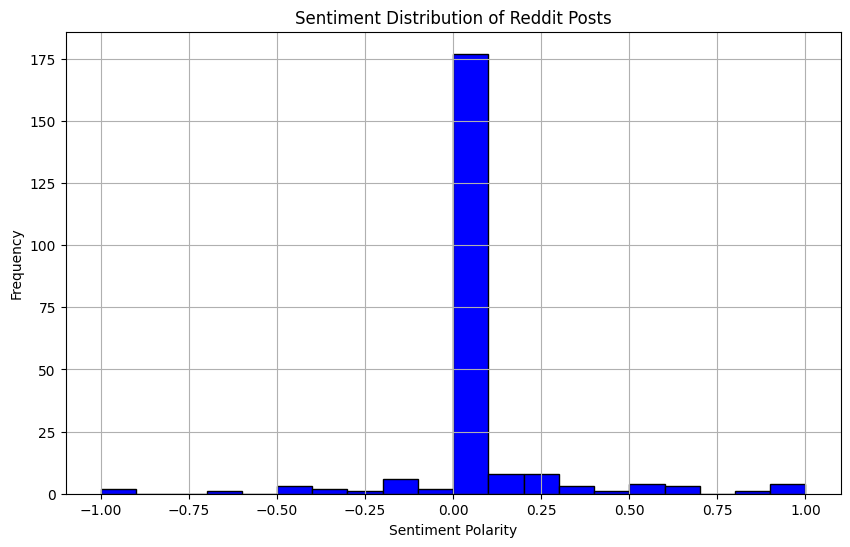

In [45]:
#Visualizing Sentimental Analysis

plt.figure(figsize=(10, 6))
plt.hist(df['Sentiment'], bins=20, color='blue', edgecolor='black')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution of Reddit Posts')
plt.grid(True)
plt.show()
#From the Graph we can infer that overall Tata Motors have a favorable reputation on Reddit

In [46]:
#Preprocessing data before futher analysis using Sklearn and Regex

df['Post'] = df['Post'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
# Convert text to numerical representation
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Post'])

In [47]:
#Performing LDA 
stop_words = set(stopwords.words('english'))
def preprocess(text):
    tokens = text.lower().split()
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens
df['Tokens'] = df['Post'].apply(preprocess)
dictionary = corpora.Dictionary(df['Tokens'])
corpus = [dictionary.doc2bow(text) for text in df['Tokens']]

# Apply LDA
lda_model = LdaModel(corpus, num_topics=4, id2word=dictionary, passes=15)

# Print topics
for topic in lda_model.print_topics():
    print(topic)
topic_distributions = [lda_model.get_document_topics(doc) for doc in corpus]

(0, '0.076*"tata" + 0.066*"motors" + 0.019*"buy" + 0.015*"time" + 0.011*"best" + 0.011*"looking" + 0.008*"shares" + 0.008*"ev" + 0.008*"cautious" + 0.008*"diversify"')
(1, '0.175*"tata" + 0.165*"motors" + 0.013*"share" + 0.010*"price" + 0.007*"buy" + 0.007*"vs" + 0.007*"time" + 0.006*"service" + 0.005*"project" + 0.005*"customer"')
(2, '0.079*"tata" + 0.071*"motors" + 0.020*"demerger" + 0.012*"india" + 0.012*"brief" + 0.012*"analysis" + 0.008*"service" + 0.008*"need" + 0.008*"launched" + 0.008*"justice"')
(3, '0.054*"tata" + 0.044*"motors" + 0.015*"growth" + 0.010*"india" + 0.010*"app" + 0.010*"maruti" + 0.010*"suzuki" + 0.010*"stock" + 0.007*"sales" + 0.006*"days"')


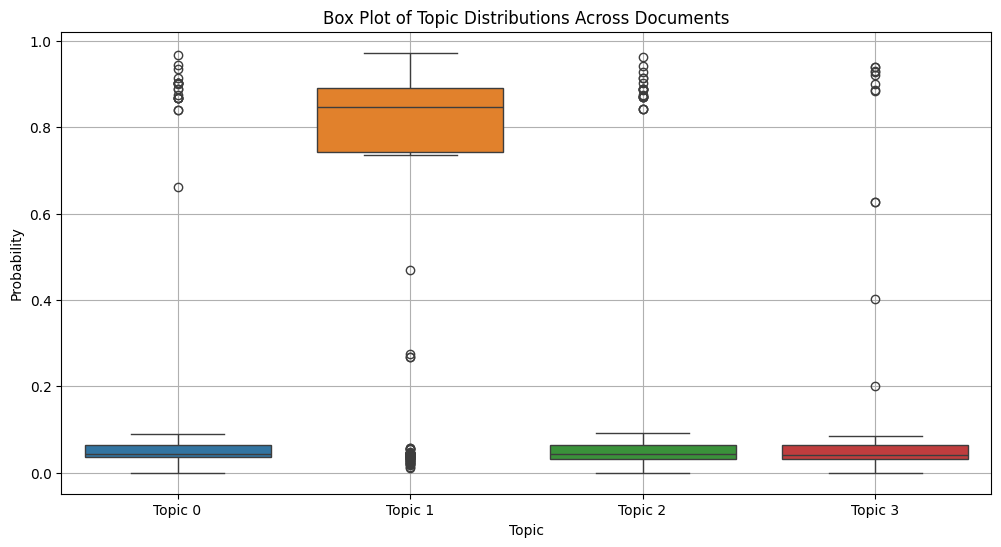

In [48]:
#Visualizing Topic Distribution Using Box Plots

topic_distribution_matrix = [[dict(doc_topics).get(t, 0) for t in range(lda_model.num_topics)] for doc_topics in topic_distributions]

# Create DataFrame for visualization
df_topic_dist = pd.DataFrame(topic_distribution_matrix, columns=[f'Topic {i}' for i in range(lda_model.num_topics)])

# Box Plot of Topic Distributions
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_topic_dist)
plt.title('Box Plot of Topic Distributions Across Documents')
plt.xlabel('Topic')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

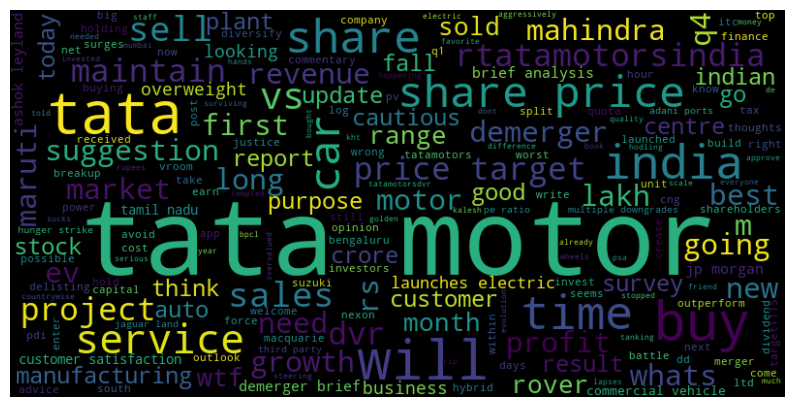

In [49]:
#Creating The word Cloud
from wordcloud import WordCloud

# Combine all posts into a single string
all_words = ' '.join([text for text in df['Post']])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(all_words)

# Plot the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

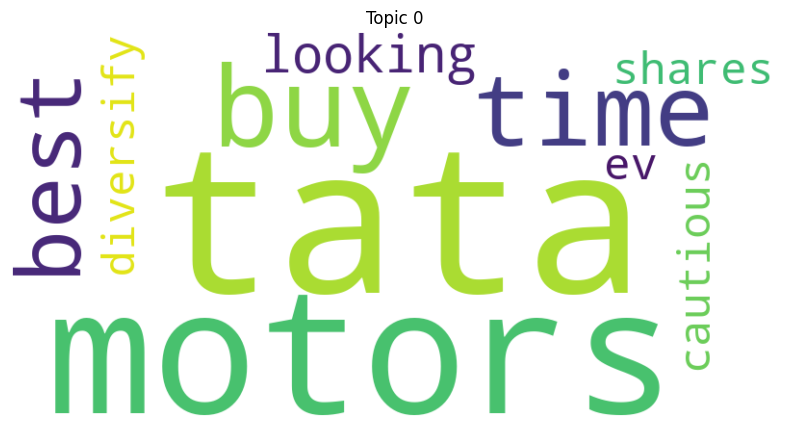

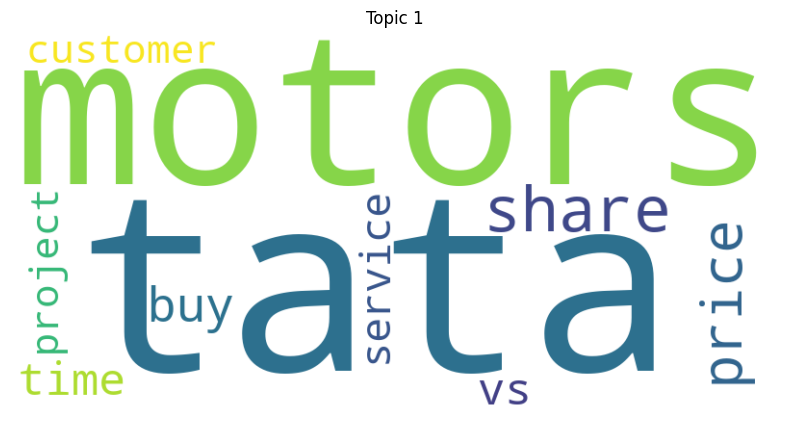

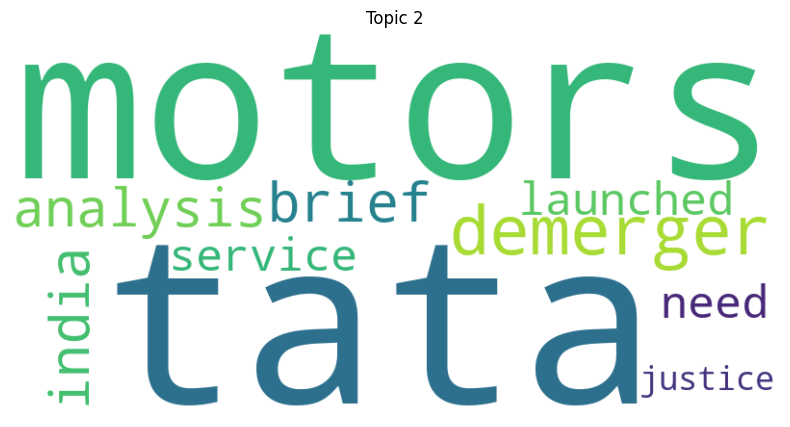

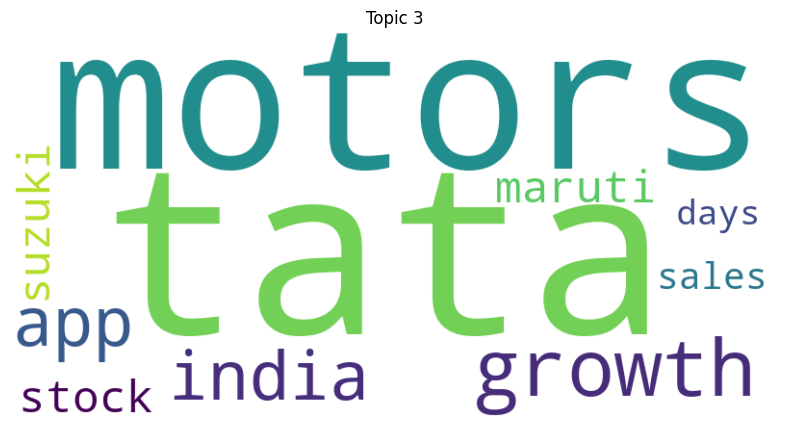

In [50]:
#word Cloud for each topic to gain more insights
def plot_wordcloud_for_topic(lda_model, topic_id, num_words=50):
    topic_words = lda_model.show_topic(topic_id)
    # Only take the top num_words words
    topic_words = topic_words[:num_words]
    word_freq = dict(topic_words)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_id}')
    plt.show()

# Plot word clouds for each topic
for topic_id in range(lda_model.num_topics):
    plot_wordcloud_for_topic(lda_model, topic_id)

<Figure size 1500x800 with 0 Axes>

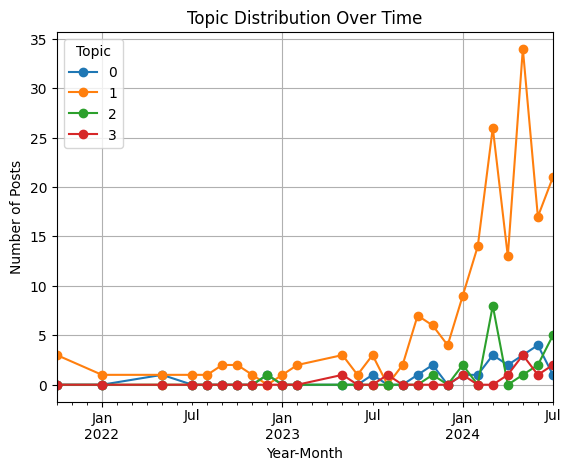

In [55]:
# Group by date to analyze sentiment over time
df['YearMonth'] = df['Timestamp'].dt.to_period('M')

#Putting each post in the most probable topic
df['Topic'] = [max(doc_topics, key=lambda x: x[1])[0] for doc_topics in topic_distributions]

topic_trends = df.groupby(['YearMonth', 'Topic']).size().unstack().fillna(0)

# Plot topic distribution over time
plt.figure(figsize=(15, 8))
topic_trends.plot(kind='line', marker='o')
plt.title('Topic Distribution Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Posts')
plt.legend(title='Topic')
plt.grid(True)
plt.show()

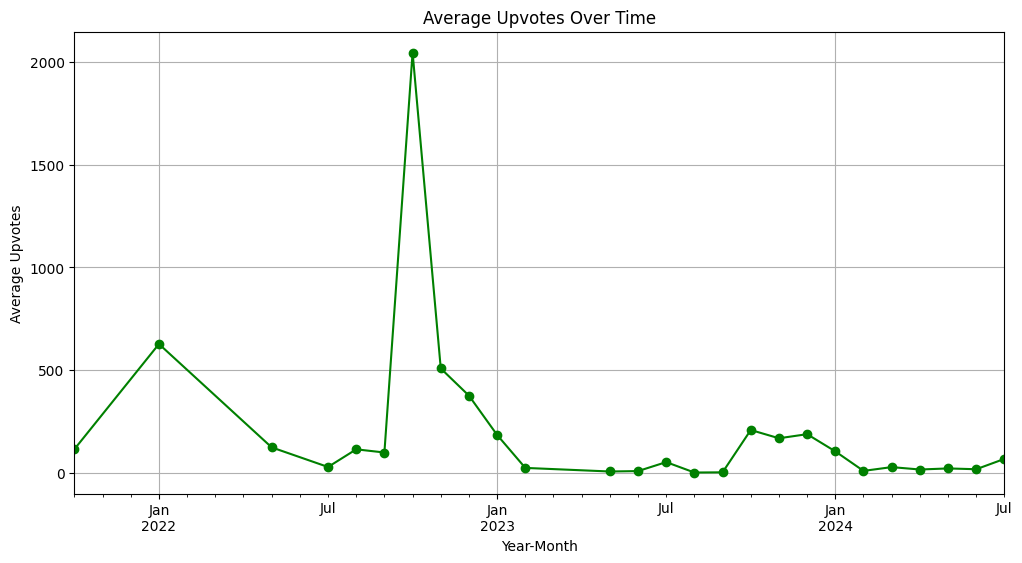

In [56]:
#Visualzing Upvotes on Reddit with time
import matplotlib.pyplot as plt

# Group by year and month and calculate average upvotes
upvote_trends = df.groupby('YearMonth')['Upvotes'].mean()

# Plot upvote trends
plt.figure(figsize=(12, 6))
upvote_trends.plot(kind='line', marker='o', color='green')
plt.title('Average Upvotes Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Average Upvotes')
plt.grid(True)
plt.show()

#The Data shows rise in upvotes and Topic 1 at same time by looking at wordcloud of Topic 1
#it's probably because of rise of EV and shares

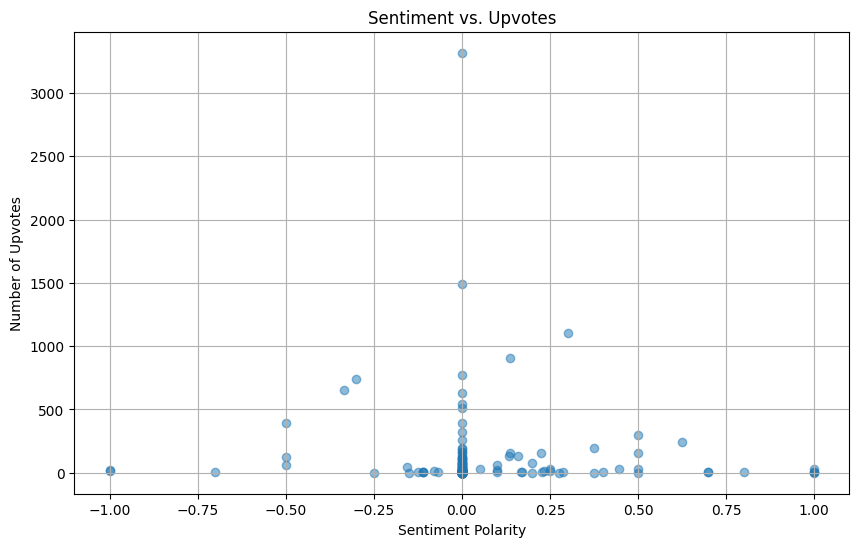

In [57]:
# Analyze the relationship between sentiment and upvotes
plt.figure(figsize=(10, 6))
plt.scatter(df['Sentiment'], df['Upvotes'], alpha=0.5)
plt.title('Sentiment vs. Upvotes')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Upvotes')
plt.grid(True)
plt.show()


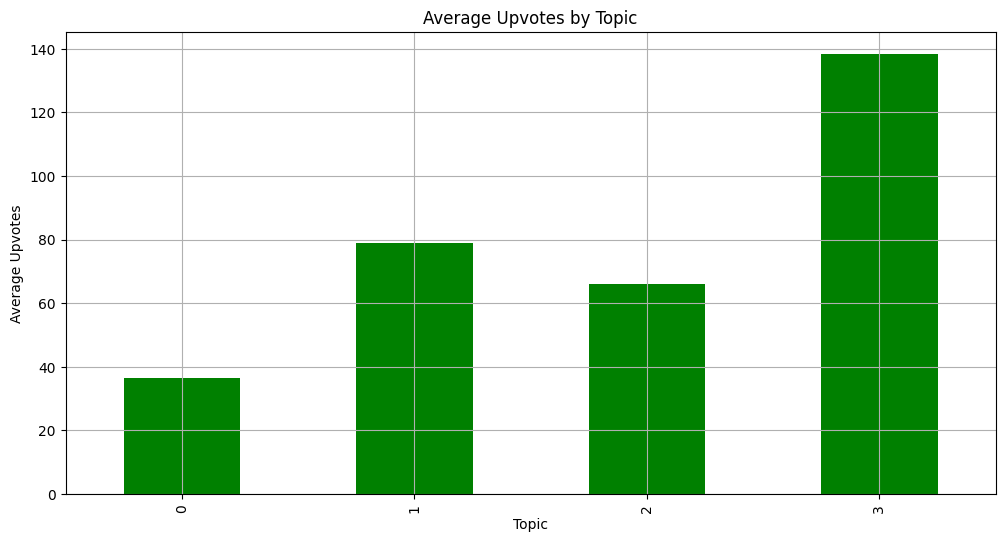

In [60]:
# Group by topic and calculate average upvotes
topic_upvotes = df.groupby('Topic')['Upvotes'].mean()

# Plot average upvotes by topic
plt.figure(figsize=(12, 6))
topic_upvotes.plot(kind='bar', color='green')
plt.title('Average Upvotes by Topic')
plt.xlabel('Topic')
plt.ylabel('Average Upvotes')
plt.grid(True)
plt.show()

#Although here we can see that more upvotes relates to Topic 3 which is linked to stocks, app,
#technology and great work of Tata to increase the Indian Economy


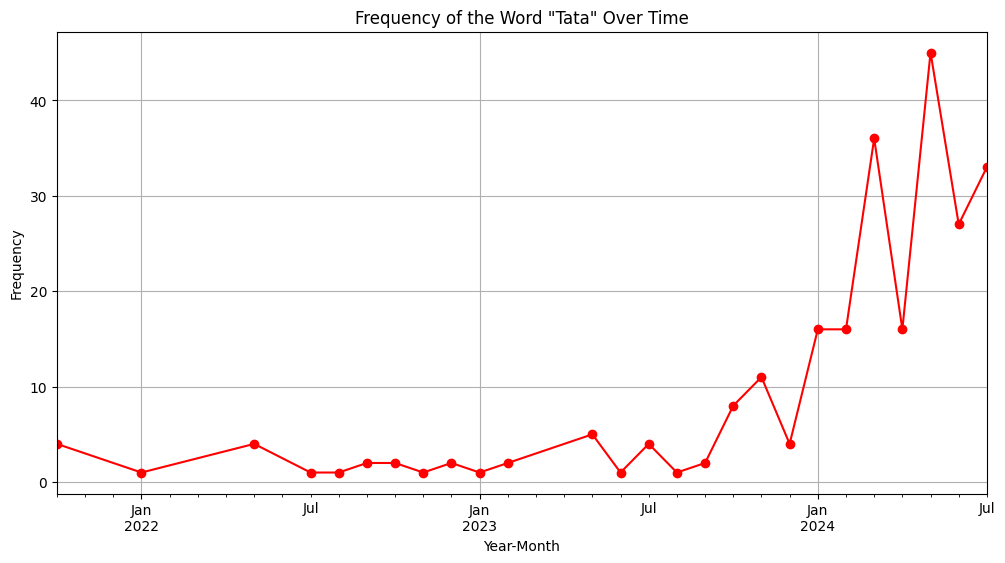

In [65]:
from collections import Counter

# Example function to extract and count words
def extract_words(text):
    return text.lower().split()

# Apply function to extract words
df['Words'] = df['Post'].apply(extract_words)

# Aggregate word counts by time period
word_counts = df.explode('Words').groupby(['YearMonth', 'Words']).size().unstack(fill_value=0)

# Plot the trend for a specific word (e.g., 'pixel')
plt.figure(figsize=(12, 6))
word_counts['tata'].plot(kind='line', marker='o', color='red')
plt.title('Frequency of the Word "Tata" Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

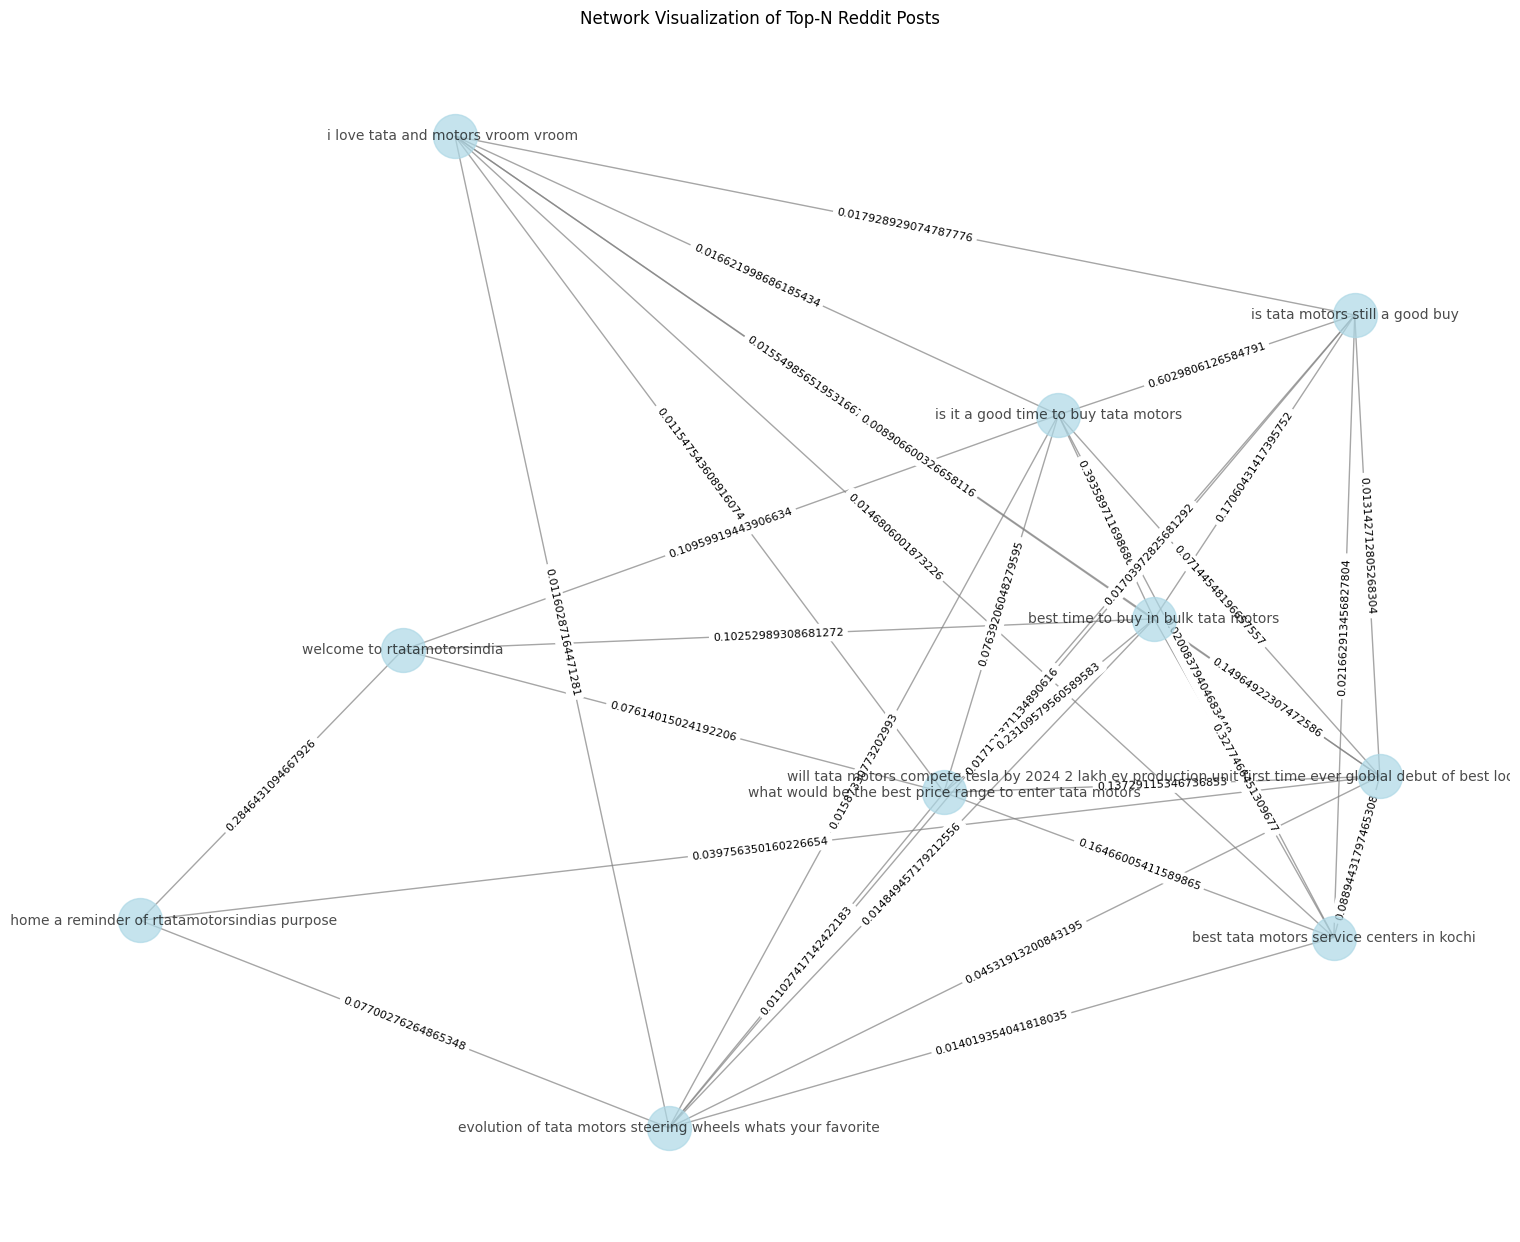

In [76]:
#Performing Network Analysis of Data to know how the word of 'Tata' is spread.


# Vectorize the posts
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Post'])

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(X, X)

G = nx.Graph()

# Add nodes with sentiment as an attribute
for index, row in df.iterrows():
    G.add_node(row['Post'], sentiment=row['Sentiment'])

# Add edges based on similarity
for i in range(len(df)):
    for j in range(i+1, len(df)):
        if cosine_sim[i, j] > 0:
            G.add_edge(df['Post'][i], df['Post'][j], weight=cosine_sim[i, j])

# Determine top N nodes based on sentiment score (or other criteria)
top_n = 10
top_nodes = sorted(G.nodes(data=True), key=lambda x: x[1]['sentiment'], reverse=True)[:top_n]
top_nodes = [node[0] for node in top_nodes]

# Filter the graph to include only top N nodes and corresponding edges
H = G.subgraph(top_nodes).copy()

# Visualization
plt.figure(figsize=(15, 12))  
# Choose layout
pos = nx.spring_layout(H, seed=42, k=0.5) 
# Draw nodes, edges, and labels
nx.draw(H, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=10, edge_color='gray', alpha=0.7)

# Draw edge labels (if needed)
edge_labels = nx.get_edge_attributes(H, 'weight')
nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=8)

plt.title('Network Visualization of Top-N Reddit Posts')
plt.show()

In [86]:
#Example of showing one of the highest posts that reached the most to people to help gain popularity

degrees = dict(G.degree())
sorted_nodes = sorted(degrees.items(), key=lambda item: item[1], reverse=True)
max_node, max_degree = sorted_nodes[1]
print(f'Node: {max_node}')
print(f'Number of connections (degree): {max_degree}')

Node: spread the tata pride share rtatamotorsindia with fellow tata owners
Number of connections (degree): 191


In [90]:
#Calculating Centrality and Partition

centrality = nx.degree_centrality(G)
partition = community_louvain.best_partition(G.to_undirected())


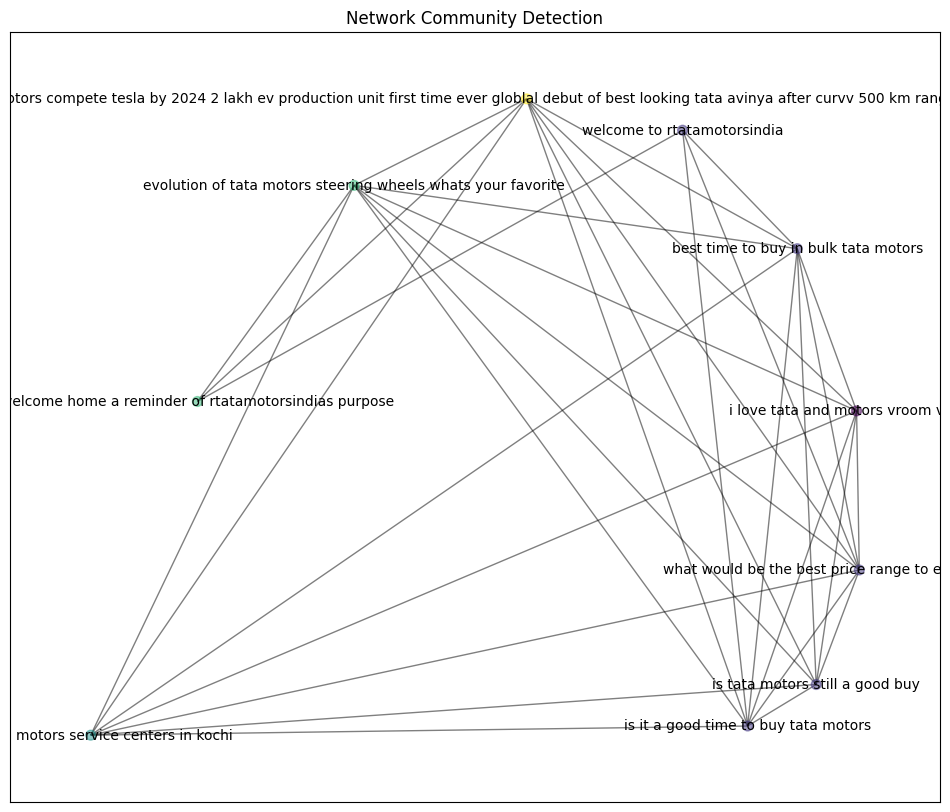

In [106]:
#Visualizing Network Community of top 10 nodes
plt.figure(figsize=(12, 10))
pos = nx.spiral_layout(H)
cmap = plt.get_cmap('viridis')
colors = [cmap(partition[node] / max(partition.values())) for node in H.nodes()]

nx.draw_networkx_nodes(H, pos, node_size=50, node_color=colors, alpha=0.5)
nx.draw_networkx_edges(H, pos, alpha=0.5)
nx.draw_networkx_labels(H, pos, font_size=10, font_color='black')

plt.title('Network Community Detection')
plt.show()